### SHARPE STYLE ANALYSIS

Sharpe Style Analysis is an elegant and simple decomposition exercise similar to Fama-French, with the added constraint that the coeeficients are all positive and add to 1. 

Therefore, the coefficients of performing style analysis on the observed return of a manager can be interpreted as weights in a portfolio of building blocks which together, mimic that return series. 

The analysis can also reveal drifts in a manager's style as well as provide insight into what the manager is likely doing to obtain the returns.


Using a quadratic optimizer, the weights that minimizes -  the square of the difference between the observed series and the returns of a benchmark portfolio that holds the building blocks in those same weights. This is equivalent to minimizing the tracking error between the two return series.

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import risk_kit as kit
%load_ext autoreload
%autoreload 2

In [2]:
def style_analysis(dependant_variables, explanatory_variables):
    """
    Returns the optimal weights that minimizes the Tracking error 
    between a portfolio of the explanatory variables and the dependant variables.
    Code is slight variation to the minimize_vol function in toolkit.
    """
    n = explanatory_variables.shape[1]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples.
    # Constraints
    weights_sum_to_1 = {
                        'type':'eq',
                        'fun': lambda weights: np.sum(weights) - 1
                        }
    solution = minimize(portfolio_tracking_error, 
                        init_guess, 
                        args = (dependant_variables, explanatory_variables,),
                        method = 'SLSQP',
                        options = {'disp':False},
                        constraints = (weights_sum_to_1,),
                        bounds = bounds
                       )
    weights = pd.Series(solution.x, index=explanatory_variables.columns)
    return weights

In [3]:
# Objective function
def portfolio_tracking_error(weights, reference_returns, buildingblock_returns):
    """
    Returns the tracking error between the reference returns 
    and a portfolio of building block returns held with given weights.
    """
    return tracking_error(reference_returns, (weights*buildingblock_returns).sum(axis=1))

In [4]:
def tracking_error(r_a, r_b):
    """
    Returns the Tracking Error between the two return series
    """
    return np.sqrt(((r_a - r_b)**2).sum())

In [5]:
# Load and format the Ken French 30 Industry Portfolios Value Weighted Monthly Returns.
ind = kit.get_ind_returns()["2000":]
ind.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
2000-01,-0.0829,-0.0228,-0.0862,0.0229,-0.0092,-0.0651,-0.1138,0.0756,-0.0933,-0.0764,...,-0.0404,-0.0973,-0.0064,-0.0878,-0.0959,0.0899,-0.1453,-0.0739,-0.0442,-0.0412
2000-02,-0.0689,-0.1164,-0.0401,-0.0177,-0.0071,-0.1157,-0.1278,-0.0288,-0.0729,-0.0584,...,-0.0359,0.0759,0.2509,-0.1142,-0.0535,0.0113,-0.0393,-0.1203,-0.0849,-0.0061
2000-03,0.0969,0.0013,0.0511,0.1052,0.1293,-0.1426,0.2506,0.0028,0.1217,0.0535,...,0.0757,0.0269,0.0456,0.0836,0.1287,0.0659,0.1436,0.1598,0.1669,-0.0016
2000-04,-0.0390,0.0368,0.0379,0.0220,-0.0734,0.0429,0.0430,0.0525,-0.0373,0.0648,...,-0.0790,-0.1655,-0.0630,-0.0109,0.0348,-0.0107,-0.0560,0.0382,-0.0425,0.0819
2000-05,0.1565,0.1187,0.1951,0.0119,-0.0593,0.0279,-0.0504,0.0394,-0.0010,-0.0328,...,-0.1041,-0.0892,-0.1165,-0.0137,-0.0363,0.0193,-0.0304,-0.0421,0.0506,0.0531


Construct a manager that invests 30% in Beer, 50% in Tobacco and 20% in other things that have an average return of 0% and an annualized volatility of 15%.

In [6]:
mgr_returns = 0.3*ind["Beer"] + 0.5*ind["Smoke"] + 0.2*np.random.normal(scale=0.15/(12**0.5), size=ind.shape[0])

***Now assume that we knew absolutely nothing about this manager and all we observed was the returns. How could we tell what she was invested in?*** 

In [7]:
weights = style_analysis(mgr_returns, ind)*100

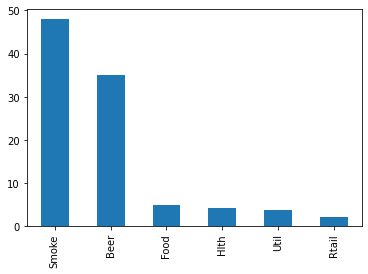

In [8]:
weights.sort_values(ascending=False).head(6).plot.bar()

In [9]:
weights.sort_values(ascending=False).head(6)

Smoke    47.939854
Beer     34.952243
Food      4.989320
Hlth      4.209746
Util      3.725941
Rtail     2.285074
dtype: float64

We can see here that when we reverse engineer the weights that we get out of the style analysis, we get something that is actually pretty close.

Then we get some small investment, 6% in utils, 4% in Household etc, which is wrong because we know that this manager did not invest in those. SO we do get some spurious answers.

But we can see that a good use of Sharpe Style Analysis is just to give a very broad picture. 

Contrast this to the results of a regression. Because the model is in fact very True (i.e. we really did construct the manager's returns out of the building blocks), the results are remarkably accurate. 

In [10]:
coeffs = kit.regress(mgr_returns, ind).params*100
coeffs.sort_values().head()

BusEq   -2.970791
Oil     -2.213114
Clths   -1.990530
Hshld   -1.743915
Fin     -1.520440
dtype: float64

The negative coefficients are really hard to interpret and in real-life data, those will be much larger. However, when it works well, such as in this artificial example here, the results can be very accurate.

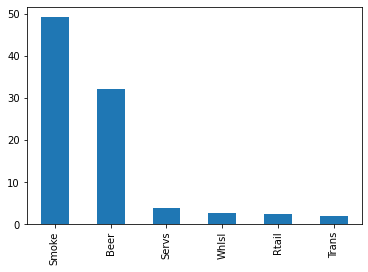

In [11]:
coeffs.sort_values(ascending=False).head(6).plot.bar()

### Warning: Potential misuse of Style Analysis

Style Analysis works best when the explanatory indices are in fact a good explanation of what is happening. For instance, it usually gives you very useful and revealing insight if you use a stock market index (such as SPY) and other broad indices, EFTs or mutual funds (such as a Value Fund, a Growth Fund, an international Fund, a Bond Fund etc).

Part of the skill in extracting meaningful results is to pick the right set of explanatory variables.

However, a part of the challenge with Style Analysis is that it will ***always*** return a portfolio. Although it is possible to develop a figure of merit of fit quality similar to an $R^{2}$, it will still always give you an answer, however unreasonable it might be, and it's not always obvious how much one can rely on the result.

For instance, we can try and extract the major industries taht Buffet invested in since 2000 as folows:

In [12]:
brka_m = pd.read_csv("data/brka_m_ret.csv", index_col=0, parse_dates=True).to_period('M')

In [13]:
mrg_returns_buffet = brka_m["2000":]["BRKA"] 
weights_buffet = kit.style_analysis(mrg_returns_buffet, ind)
weights_buffet.sort_values(ascending=False).head(6).round(4)*100

Food     41.35
Fin      17.61
Meals    12.11
Other    11.03
Util      7.19
Clths     5.99
dtype: float64

If we want to look at the last decade:

In [14]:
brk2009 = brka_m["2009":]["BRKA"]
ind2009 = ind["2009":]
kit.style_analysis(brk2009, ind2009).sort_values(ascending=False).head(6).round(4)*100

Other    43.64
Food     28.33
Hlth     22.72
Rtail     5.25
Meals     0.07
Books     0.00
dtype: float64

Should you believe this analysis? *Probably not*. However, when the specification is in fact accurate (as we saw in the artificially generated series) the results can be very revealing.